# Classifier using PyTorch

In this notebook we train an MLP classifier on the MINST dataset.

In [2]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

## replace with your own root directory
ROOT="/Users/adnan/Programming for Data-Science/Artificial-Intelligence"

Load the MNIST dataset. This will download a copy to your machine on first use. 

In [3]:
# Load the datasets
train_set = torchvision.datasets.MNIST(
    root='./classifier_data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.MNIST(
    root='./classifier_data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Inspect some of the data.

In [4]:
# change the subset value and check how a tensor array is classified to a number from 0-9
train_set[5]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
data, label = train_set[4]
print(data.size()) # (Color,Width,Height)
print(label)

torch.Size([1, 28, 28])
9


Create some iterable Data Loaders for easy iteration on mini-batches during training and testing. Also, initialise an array with the 10 class IDs.

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


Show some images and labels as a sanity check.
Use `torchvision.utils.make_grid` to create one image from a set of images. Note that this function converts single channel (grey-scale) tensors to have three channels. This is done by replicating the values into red, green and blue channels.

Grey -> RGB

torch.Size([16, 1, 28, 28])


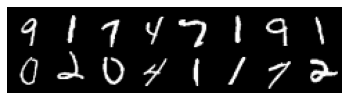

9 1 7 4 7 1 9 1 0 2 0 4 1 1 7 2


In [7]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0)) # Transpose bcz it wants -> (Width,Height,Color)
    plt.imshow(xa) 
    plt.axis('off')
    plt.show()
    return xa
    
# get a batch of random training examples (images and corresponding labels)
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
print(images.size())
timshow(torchvision.utils.make_grid(images))
print(*labels.numpy())     # asterisk unpacks the ndarray

## Build a classifier
We use the `torch.nn` and `torch.optim` packages. These provide a simple way to build networks without losing sight of the iterative steps in gradient descent.

First we construct the classifer function using the nn.Sequential wrapper that simply sequences the steps in the classifier function. In the case of a linear classifier there is just one nn.Linear layer. This is preceeded by `nn.Flatten` that vectorises a $28\times28$ input image into a 1D vector of length $28*28$. We will also experiment with a two layer classifier.

In [9]:
# 1-layer
net_1layer = nn.Sequential(
    nn.Flatten(),
    
#     single layer
    nn.Linear(28*28, 10)
    
    # two layers
#     nn.Linear(28*28, 300),
#     nn.Sigmoid(),
#     nn.Linear(300,10)
)

for param in net_1layer.parameters():
    print(param.shape)

torch.Size([10, 784])
torch.Size([10])


In [11]:
# 2-layers
net_2layer = nn.Sequential(
    nn.Flatten(),
    
#     single layer
#    nn.Linear(28*28, 10)
    
#    two layers
    nn.Linear(28*28, 300),
    nn.Sigmoid(),
    nn.Linear(300,10)
)

for param in net_2layer.parameters():
    print(param.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


Train the network. For the two-layer network you'll need at least 200 epochs. 50 epochs will be more than enough for the one-layer network, but we'll run for the same number of epochs as for the two-layer network to give the full curve in the plot below.

In [12]:
nepochs = 200    # number of epochs
results_path = 'linear1layer200epochs.pt'

# initialise ndarray to store the mean loss in each epoch (on the training data)
losses = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.

loss_fn = nn.CrossEntropyLoss() # Note, this takes log(Softmax) and Log-Likelihood
                                # Meaning, it takes out the prob. of an input to be equal to a certain output
                                # and tell us of the loss..how much it is not so
optimizer = optim.SGD(net_1layer.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    
    for data in train_loader:
        inputs, labels = data
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net_1layer(inputs) # A map of input(784) - output(10) is made..
                              # connections have what is called weights/coeffs, imagine like a computational graph
                              # each of 784 points connected to 10 points, we need gradient of each now,
                              # To Optimise.
        loss = loss_fn(outputs, labels)
        loss.backward() # Assigns gradients to each connection/weight/coeff. of the input - output in a Matrix
        optimizer.step() # Updates the matrix with new weights, considering the step size..like p = p - stepsize*grad

        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1
       
    # record the mean loss for this epoch and show progress
    losses[epoch] = running_loss / n
    print(f"epoch: {epoch+1} loss: {losses[epoch] : .3f}")
    
# save network parameters and losses
torch.save({"state_dict": net_1layer.state_dict(), "losses": losses}, results_path)
   

epoch: 1 loss:  0.614
epoch: 2 loss:  0.389
epoch: 3 loss:  0.354
epoch: 4 loss:  0.336
epoch: 5 loss:  0.324
epoch: 6 loss:  0.316
epoch: 7 loss:  0.309
epoch: 8 loss:  0.304
epoch: 9 loss:  0.300
epoch: 10 loss:  0.296
epoch: 11 loss:  0.293
epoch: 12 loss:  0.291
epoch: 13 loss:  0.288
epoch: 14 loss:  0.286
epoch: 15 loss:  0.284
epoch: 16 loss:  0.283
epoch: 17 loss:  0.281
epoch: 18 loss:  0.279
epoch: 19 loss:  0.278
epoch: 20 loss:  0.277
epoch: 21 loss:  0.276
epoch: 22 loss:  0.275
epoch: 23 loss:  0.274
epoch: 24 loss:  0.273
epoch: 25 loss:  0.272
epoch: 26 loss:  0.271
epoch: 27 loss:  0.270
epoch: 28 loss:  0.270
epoch: 29 loss:  0.269
epoch: 30 loss:  0.268
epoch: 31 loss:  0.267
epoch: 32 loss:  0.267
epoch: 33 loss:  0.266
epoch: 34 loss:  0.266
epoch: 35 loss:  0.265
epoch: 36 loss:  0.265
epoch: 37 loss:  0.264
epoch: 38 loss:  0.264
epoch: 39 loss:  0.263
epoch: 40 loss:  0.263
epoch: 41 loss:  0.262
epoch: 42 loss:  0.262
epoch: 43 loss:  0.261
epoch: 44 loss:  0.2

Notice that the first dimension of inputs and outputs corresponds to a minibatch of examples.

In [13]:
print(f"input size: {inputs.size()}, output size: {outputs.size()}")

input size: torch.Size([16, 1, 28, 28]), output size: torch.Size([16, 10])


In [14]:
nepochs = 200    # number of epochs
results_path = 'linear2layer200epochs.pt'

# initialise ndarray to store the mean loss in each epoch (on the training data)
losses = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.

loss_fn = nn.CrossEntropyLoss() # Note, this takes log(Softmax) and Log-Likelihood
                                # Meaning, it takes out the prob. of an input to be equal to a certain output
                                # and tell us of the loss..how much it is not so
optimizer = optim.SGD(net_2layer.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    
    for data in train_loader:
        inputs, labels = data
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net_2layer(inputs) # A map of input(784) - output(10) is made..
                              # connections have what is called weights/coeffs, imagine like a computational graph
                              # each of 784 points connected to 10 points, we need gradient of each now,
                              # To Optimise.
        loss = loss_fn(outputs, labels)
        loss.backward() # Assigns gradients to each connection/weight/coeff. of the input - output in a Matrix
        optimizer.step() # Updates the matrix with new weights, considering the step size..like p = p - stepsize*grad

        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1
       
    # record the mean loss for this epoch and show progress
    losses[epoch] = running_loss / n
    print(f"epoch: {epoch+1} loss: {losses[epoch] : .3f}")
    
# save network parameters and losses
torch.save({"state_dict": net_2layer.state_dict(), "losses": losses}, results_path)
   

epoch: 1 loss:  1.372
epoch: 2 loss:  0.540
epoch: 3 loss:  0.415
epoch: 4 loss:  0.369
epoch: 5 loss:  0.344
epoch: 6 loss:  0.328
epoch: 7 loss:  0.316
epoch: 8 loss:  0.307
epoch: 9 loss:  0.299
epoch: 10 loss:  0.293
epoch: 11 loss:  0.287
epoch: 12 loss:  0.282
epoch: 13 loss:  0.277
epoch: 14 loss:  0.272
epoch: 15 loss:  0.267
epoch: 16 loss:  0.262
epoch: 17 loss:  0.258
epoch: 18 loss:  0.253
epoch: 19 loss:  0.248
epoch: 20 loss:  0.244
epoch: 21 loss:  0.240
epoch: 22 loss:  0.235
epoch: 23 loss:  0.231
epoch: 24 loss:  0.226
epoch: 25 loss:  0.222
epoch: 26 loss:  0.217
epoch: 27 loss:  0.213
epoch: 28 loss:  0.209
epoch: 29 loss:  0.206
epoch: 30 loss:  0.202
epoch: 31 loss:  0.198
epoch: 32 loss:  0.194
epoch: 33 loss:  0.191
epoch: 34 loss:  0.187
epoch: 35 loss:  0.184
epoch: 36 loss:  0.180
epoch: 37 loss:  0.177
epoch: 38 loss:  0.174
epoch: 39 loss:  0.171
epoch: 40 loss:  0.168
epoch: 41 loss:  0.165
epoch: 42 loss:  0.163
epoch: 43 loss:  0.160
epoch: 44 loss:  0.1

Compare the history of the loss function during training (mean loss in each epoch) for 1 and 2 layer models

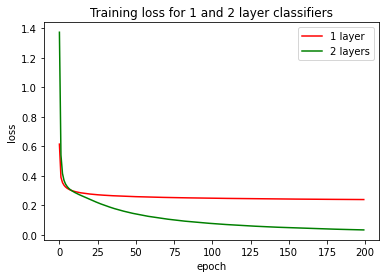

In [15]:
d1 = torch.load('linear1layer200epochs.pt')
d2 = torch.load('linear2layer200epochs.pt')

fig = plt.figure()

plt.plot(d1["losses"], 'r', label = '1 layer', )
plt.plot(d2["losses"], 'g', label = '2 layers' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss for 1 and 2 layer classifiers')

fig.savefig("training_loss_MNIST.svg")
plt.show()

How does the trained classifier `net` perform on the test set? First define our performance measures in terms of a given confusion matrix.

In [16]:
# Weights, w from wx+b
# Bias, b from wx+b
for  i in net_2layer.parameters():
    print(i)

Parameter containing:
tensor([[-0.0147, -0.0060,  0.0245,  ...,  0.0179, -0.0320, -0.0295],
        [-0.0138,  0.0224,  0.0335,  ..., -0.0325, -0.0247, -0.0065],
        [ 0.0145,  0.0156,  0.0193,  ..., -0.0311, -0.0173, -0.0155],
        ...,
        [-0.0191, -0.0318,  0.0323,  ..., -0.0335, -0.0066,  0.0075],
        [-0.0214,  0.0071, -0.0070,  ..., -0.0027, -0.0098,  0.0214],
        [ 0.0061,  0.0247, -0.0222,  ...,  0.0278,  0.0174,  0.0195]],
       requires_grad=True)
Parameter containing:
tensor([-1.0097e-01, -2.5282e-02,  5.4313e-02,  3.3446e-01, -8.2347e-02,
         4.2241e-02, -2.2882e-01,  8.2888e-02,  7.6454e-02, -6.0717e-02,
        -1.0105e-01,  1.1075e-01,  3.0702e-02,  9.0859e-02, -6.1725e-02,
         4.8058e-03, -8.5959e-02, -1.6576e-02,  5.4720e-03,  7.8994e-02,
        -3.2773e-02, -1.5465e-02,  4.7161e-02, -2.6032e-02, -2.5957e-02,
        -3.3975e-02, -6.7332e-02,  2.0216e-01, -2.1667e-02,  7.9158e-02,
        -3.9701e-02, -2.4107e-01, -1.9887e-01, -1.2936e-0

In [17]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)    

Run the model on test data, build a confusion matrix and compute performance measures.

Confusion matrix
[[ 960    0    1    3    0    7    4    4    1    0]
 [   0 1114    3    1    0    2    4    2    9    0]
 [   6   10  929   16    9    4   13    9   31    5]
 [   4    1   15  924    0   27    3   11   17    8]
 [   1    2    6    3  918    0    8    4    9   31]
 [  10    2    3   33    9  788   13    5   26    3]
 [   9    3    8    2    8   18  907    2    1    0]
 [   1    8   22    8    8    1    0  950    2   28]
 [   9   12    8   25    9   34   11    8  845   13]
 [  11    8    1   10   26    7    0   20    6  920]]
Accuracy: 92.5%
Class 0 : Precision 95.0%  Recall 98.0%
Class 1 : Precision 96.0%  Recall 98.1%
Class 2 : Precision 93.3%  Recall 90.0%
Class 3 : Precision 90.1%  Recall 91.5%
Class 4 : Precision 93.0%  Recall 93.5%
Class 5 : Precision 88.7%  Recall 88.3%
Class 6 : Precision 94.2%  Recall 94.7%
Class 7 : Precision 93.6%  Recall 92.4%
Class 8 : Precision 89.2%  Recall 86.8%
Class 9 : Precision 91.3%  Recall 91.2%


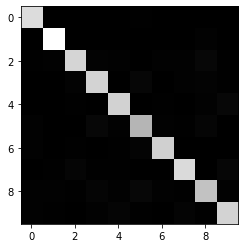

In [20]:
d = torch.load('linear1layer200epochs.pt')
# now load the parameter state into the current model (make sure this is the right model).
net_1layer.load_state_dict(d["state_dict"])

# initialise confusion matrix
nclasses = classes.shape[0]
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_1layer(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
       
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix")
print(cnfm)

# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")
